<a href="https://colab.research.google.com/github/PaulinaRuizB/Machine_Learning_Theory/blob/main/Homeworks/Deep%20Learning/Cuaderno_4_Introducci%C3%B3n_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ejercicio 1

Consultar el modelo y principio de optimización de los modelos de media móvil (Moving average - MA), autorregresivos de media móvil (Autorregresive moving average - ARMA) y autorregresivo integrado de media móvil (Autoregressive integrated moving average). Cuáles son sus relaciones con los modelos Markovianos?.

# Modelos MA, ARMA y ARIMA y su relación con los Modelos Markovianos

## Modelo de Media Móvil (MA)

El modelo de **Media Móvil (MA)** describe una serie temporal como una combinación lineal de **errores aleatorios (ruido blanco)** presentes y pasados.

Matemáticamente, un modelo MA(q) se expresa como:

$$
X_t = \mu + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \cdots + \theta_q \varepsilon_{t-q}
$$

Donde:

- \( X_t \) es el valor de la serie en el tiempo \( t \)
- \( \mu \) es la media de la serie
- \( \varepsilon_t \) es el término de error aleatorio o "ruido blanco" (\( \varepsilon_t \sim N(0, \sigma^2) \))
- \( \theta_i \) son los parámetros del modelo MA

**Interpretación:**  
Cada observación depende de los errores pasados. Por tanto, el modelo "promedia" las perturbaciones recientes para suavizar el comportamiento de la serie.


---

## Modelo Autorregresivo de Media Móvil (ARMA)

El modelo **ARMA(p, q)** combina las ideas de **autorregresión (AR)** y **media móvil (MA)**.  

La forma general es:

$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \cdots + \phi_p X_{t-p} + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \cdots + \theta_q \varepsilon_{t-q}
$$

Donde:

- \( \phi_i \): coeficientes autorregresivos  
- \( \theta_j \): coeficientes de media móvil  
- \( \varepsilon_t \): error aleatorio en el tiempo \( t \)

**Interpretación:**  
- La parte **AR** modela la **dependencia lineal de los valores pasados**.  
- La parte **MA** modela la **dependencia de los errores pasados**.  
Este modelo se usa cuando la serie es **estacionaria** (la media y varianza no cambian con el tiempo).


---

## Modelo Autorregresivo Integrado de Media Móvil (ARIMA)

Cuando una serie **no es estacionaria**, puede hacerse estacionaria aplicando **diferencias sucesivas**.  
El modelo **ARIMA(p, d, q)** introduce el parámetro \( d \), que representa el número de veces que se diferencia la serie.

Su expresión general es:

$$
\nabla^d X_t = \phi_1 \nabla^d X_{t-1} + \cdots + \phi_p \nabla^d X_{t-p} + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \cdots + \theta_q \varepsilon_{t-q}
$$

donde \( \nabla^d X_t \) denota la **d-ésima diferencia** de la serie:

$$
\nabla^d X_t = (1 - B)^d X_t
$$

siendo \( B \) el **operador de retardo** definido como \( BX_t = X_{t-1} \).

**Interpretación:**  
El modelo ARIMA permite capturar tanto las **dependencias pasadas** como las **tendencias** (no estacionariedad) mediante el proceso de diferenciación.


---

## Relación con los Modelos Markovianos

Un **proceso de Markov** es aquel donde el **estado futuro depende solo del estado presente**, y no de toda la historia pasada:

$$
P(X_{t+1} | X_t, X_{t-1}, \ldots, X_1) = P(X_{t+1} | X_t)
$$

**Relación conceptual:**

- Los modelos **AR(p)** y **ARMA(p, q)** pueden considerarse **procesos Markovianos de orden \( p \)**, ya que el valor futuro depende de un número limitado de estados pasados (hasta \( p \)).
- En un **AR(1)**, la dependencia es estrictamente de primer orden, por lo que **equivale a un proceso de Markov de primer orden**.
- Los modelos **MA(q)** no son estrictamente Markovianos porque dependen de los errores pasados (\( \varepsilon_{t-i} \)) y no directamente de los estados pasados de la serie, pero pueden representarse como procesos de Markov en un espacio de estado extendido.



## Ejercicio 2

Para el modelo definido, determine los tamaños de las matrices y vectores de bias en cada capa.


Librerías

In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
#-------------------------------------------------------------------------------
np.random.seed(42)
tf.random.set_seed(42)
#-------------------------------------------------------------------------------
#
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Generación de las series

In [2]:
# definimos función para generar señales 1D-------------------------------------
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time   = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

#-------------------------------------------------------------------------------
# definimos número de steps y batch_size----------------------------------------
n_steps    = 50
batch_size = 10000
#-------------------------------------------------------------------------------
series           = generate_time_series(batch_size, n_steps + 1)
print('Series dimension:',series.shape)
#-------------------------------------------------------------------------------
# partimos en conjuntos de train/valid/test-------------------------------------
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
#-------------------------------------------------------------------------------
print('Train dimensions:',X_train.shape, y_train.shape)
print('Valid dimensions:',X_valid.shape, y_valid.shape)
print('Test dimensions:',X_test.shape, y_test.shape)



Series dimension: (10000, 51, 1)
Train dimensions: (7000, 50, 1) (7000, 1)
Valid dimensions: (2000, 50, 1) (2000, 1)
Test dimensions: (1000, 50, 1) (1000, 1)


In [3]:
y_train # vector de salida

array([[-0.35489398],
       [ 0.11629631],
       [-0.35395944],
       ...,
       [ 0.04946356],
       [-0.26231018],
       [ 0.60062087]], dtype=float32)

In [4]:
# definimos función para graficar las series------------------------------------
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

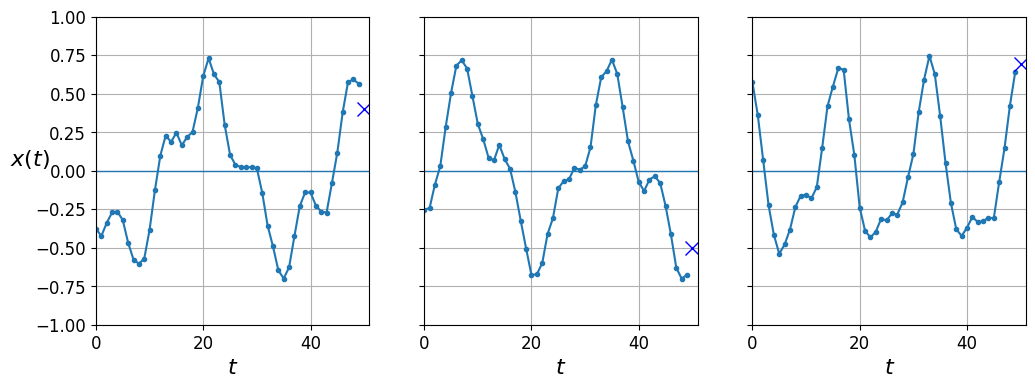

In [5]:
# graficamos 3 series del set validation----------------------------------------
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

Modelo Deep RNN

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 20)       │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

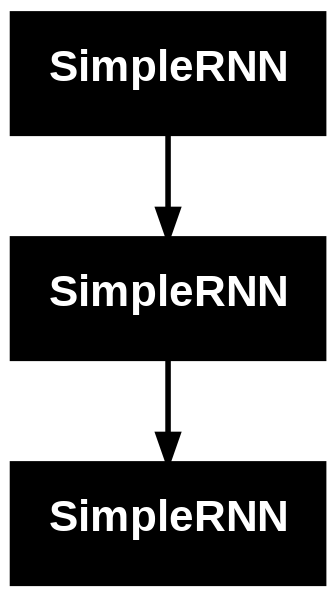

In [6]:
# definimos el modelo Deep RNN como un stack de SimpleRNN-----------------------
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1,activation='linear')
    ])

# pintamos el diagrama de bloques del modelo
model.summary()
tf.keras.utils.plot_model(model)

In [11]:
# compilamos el modelo----------------------------------------------------------
model.compile(loss="mse", optimizer="adam")
# definimos el número de épocas
epochs = 10
# entrenamos y ajustamos el modelo----------------------------------------------
history = model.fit(X_train, y_train, epochs=epochs,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0121 - val_loss: 0.0039
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0032 - val_loss: 0.0028


In [14]:
y_pred = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [15]:
for i, layer in enumerate(model.layers):
    print(f"Capa {i+1}: {layer.name}") # Removed (layer.output_shape) to fix the AttributeError
    weights_list = layer.get_weights()

    if weights_list:
        if len(weights_list) == 3:
            kernel_shape = weights_list[0].shape
            recurrent_kernel_shape = weights_list[1].shape
            bias_shape = weights_list[2].shape

            print(f"  Matriz de pesos (input a recurrente): {kernel_shape}")
            print(f"  Matriz de pesos recurrente (recurrente a recurrente): {recurrent_kernel_shape}")
            print(f"  Vector de bias: {bias_shape}")
        else:
            print(f"  Componentes de pesos encontrados: {len(weights_list)}")
            for j, weights in enumerate(weights_list):
                print(f"  Componente de pesos {j+1} (forma): {weights.shape}")
    else:
        print("  No tiene pesos entrenables (e.g., capas de activación sin parámetros).")

Capa 1: simple_rnn
  Matriz de pesos (input a recurrente): (1, 20)
  Matriz de pesos recurrente (recurrente a recurrente): (20, 20)
  Vector de bias: (20,)
Capa 2: simple_rnn_1
  Matriz de pesos (input a recurrente): (20, 20)
  Matriz de pesos recurrente (recurrente a recurrente): (20, 20)
  Vector de bias: (20,)
Capa 3: simple_rnn_2
  Matriz de pesos (input a recurrente): (20, 1)
  Matriz de pesos recurrente (recurrente a recurrente): (1, 1)
  Vector de bias: (1,)


## Ejercicio 3

1. Consulte en qué consisten las capas Conv1D y cómo pueden aplicarse para modelar series temporales.

### **Capas Conv1D y su aplicación en series temporales**

Las capas **Conv1D (Convolutional 1D)** son un tipo de capa convolucional utilizada para procesar datos **secuenciales unidimensionales**, como **series temporales**, **señales de audio** o **texto**.  
Su función principal es **extraer patrones locales** en el eje temporal mediante filtros que se desplazan a lo largo de la secuencia.

---

### **1. Funcionamiento matemático**

Una capa **Conv1D** aplica un conjunto de **filtros** o **kernels** sobre la entrada.  
Cada filtro realiza una **convolución** sobre una ventana de tamaño \( k \), combinando linealmente los valores dentro de dicha ventana.

Matemáticamente, la convolución discreta se define como:

$$
y(t) = (x * w)(t) = \sum_{i=0}^{k-1} w_i \, x_{t-i}
$$

donde:
- \( y(t) \): salida en el tiempo \( t \)
- \( w_i \): pesos del filtro (aprendidos por la red)
- \( x_{t-i} \): valores de entrada dentro de la ventana temporal
- \( k \): tamaño del filtro o kernel

Durante el entrenamiento, los pesos \( w_i \) se ajustan para minimizar una función de pérdida, permitiendo a la red **aprender patrones temporales locales**.

---

### **2. Características principales**

- **Entrada esperada:** tensor de forma `(batch\_size, steps, features)`  
- **Desplazamiento:** los filtros se mueven a lo largo del eje temporal  
- **Parámetros clave:**
  - `filters`: número de filtros o mapas de características
  - `kernel_size`: tamaño de la ventana temporal
  - `strides`: paso con el que se mueve el filtro
  - `activation`: función de activación (ReLU, tanh, etc.)

---

### **3. Aplicación en series temporales**

En el contexto de **modelado de series temporales**, las capas **Conv1D** se usan para detectar **patrones locales en el tiempo**, como:
- Tendencias o comportamientos de corto plazo  
- Periodicidades  
- Cambios bruscos o transiciones rápidas  

A diferencia de una red recurrente (RNN, LSTM, GRU), que procesa la secuencia paso a paso, la **Conv1D analiza en paralelo** todas las posiciones del tiempo dentro de su ventana \( k \), siendo **computacionalmente más eficiente**.

Por ejemplo, si una red Conv1D utiliza un filtro con \( k = 5 \), la salida en cada instante depende de los 5 valores anteriores:

$$
\hat{y}(t) = f(x_{t}, x_{t-1}, x_{t-2}, x_{t-3}, x_{t-4})
$$

donde \( f \) representa la función no lineal aprendida por la red.



2. Realice una comparación entre las redes tipo RNN simple, LSTM, GRU y Conv1D en terminos de la capacidad de predicción en términos del mse y el mae, en los datos simulados para diferentes horizontes: {1,2,3,...,15}

In [19]:
# --- Función para generar las señales
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time   = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # noise
    return series[..., np.newaxis].astype(np.float32)

# --- Parámetros
n_steps = 50
batch_size = 10000
series = generate_time_series(batch_size, n_steps + 15)  # más pasos para horizontes

# --- División de datos
X_train, y_train = series[:7000, :n_steps], series[:7000, n_steps:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, n_steps:]
X_test, y_test = series[9000:, :n_steps], series[9000:, n_steps:]

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def train_and_evaluate(model, horizon):
    # horizon = cuántos pasos adelante queremos predecir
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    model.fit(X_train, y_train[:, :horizon], epochs=10,
              validation_data=(X_valid, y_valid[:, :horizon]),
              verbose=0)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test[:, :horizon].reshape(-1),
                             y_pred.reshape(-1))
    mae = mean_absolute_error(y_test[:, :horizon].reshape(-1),
                              y_pred.reshape(-1))
    return mse, mae


In [21]:
def build_models():
    models = {
        "SimpleRNN": keras.models.Sequential([
            keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
            keras.layers.SimpleRNN(20),
            keras.layers.Dense(15)  # salida para los 15 pasos
        ]),
        "LSTM": keras.models.Sequential([
            keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
            keras.layers.LSTM(20),
            keras.layers.Dense(15)
        ]),
        "GRU": keras.models.Sequential([
            keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
            keras.layers.GRU(20),
            keras.layers.Dense(15)
        ]),
        "Conv1D": keras.models.Sequential([
            keras.layers.Conv1D(32, 5, 1, activation="relu", input_shape=[None, 1]),
            keras.layers.Conv1D(16, 3, 1, activation="relu"),
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Dense(15)
        ])
    }
    return models


In [24]:
results = {}

for name in ["SimpleRNN", "LSTM", "GRU", "Conv1D"]:
    mse_list, mae_list = [], []
    print(f"\nEntrenando modelo: {name}")

    for horizon in range(1, 16):
        # --- Construir modelo según tipo y horizonte ---
        if name == "SimpleRNN":
            model = keras.models.Sequential([
                keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
                keras.layers.SimpleRNN(20),
                keras.layers.Dense(horizon)
            ])
        elif name == "LSTM":
            model = keras.models.Sequential([
                keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
                keras.layers.LSTM(20),
                keras.layers.Dense(horizon)
            ])
        elif name == "GRU":
            model = keras.models.Sequential([
                keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
                keras.layers.GRU(20),
                keras.layers.Dense(horizon)
            ])
        elif name == "Conv1D":
            model = keras.models.Sequential([
                keras.layers.Conv1D(32, 5, activation="relu", input_shape=[None, 1]),
                keras.layers.Conv1D(16, 3, activation="relu"),
                keras.layers.GlobalAveragePooling1D(),
                keras.layers.Dense(horizon)
            ])

        # --- Compilar y entrenar ---
        model.compile(loss="mse", optimizer="adam", metrics=["mae"])
        model.fit(X_train, y_train[:, :horizon], epochs=10,
                  validation_data=(X_valid, y_valid[:, :horizon]),
                  verbose=0)

        # --- Evaluar ---
        y_pred = model.predict(X_test)
        y_true = y_test[:, :horizon]

        mse = mean_squared_error(y_true.reshape(-1), y_pred.reshape(-1))
        mae = mean_absolute_error(y_true.reshape(-1), y_pred.reshape(-1))

        mse_list.append(mse)
        mae_list.append(mae)

    results[name] = {"MSE": mse_list, "MAE": mae_list}



Entrenando modelo: SimpleRNN
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Entrenando modelo: LSTM


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Entrenando modelo: GRU


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Entrenando modelo: Conv1D


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


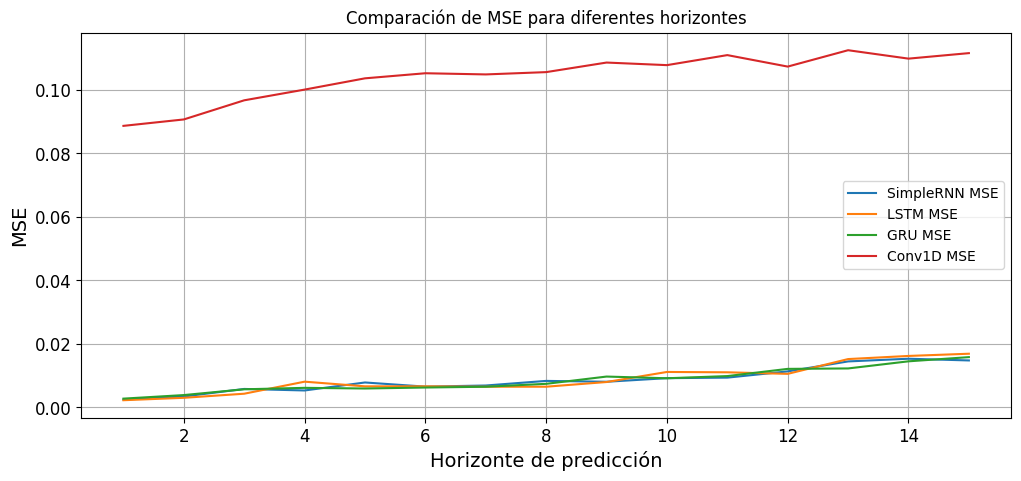

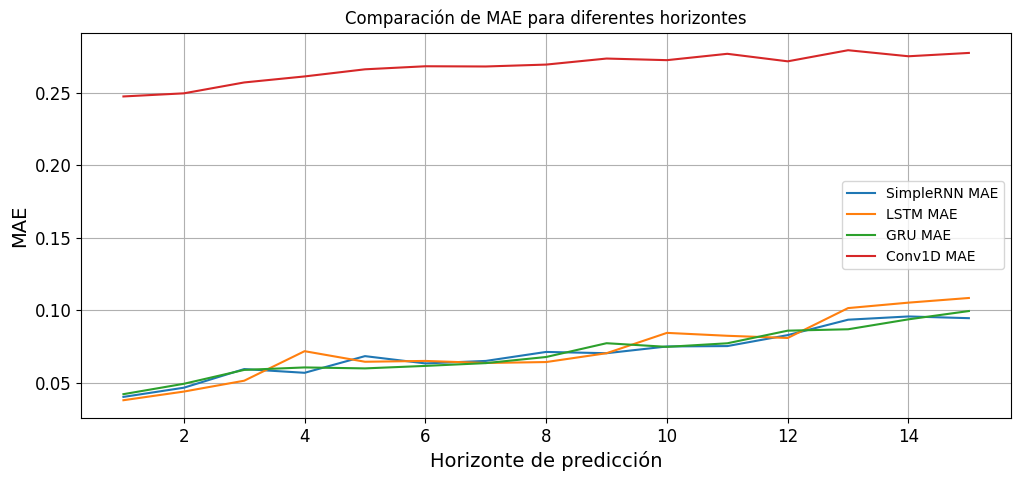

In [25]:
plt.figure(figsize=(12, 5))
for name in results:
    plt.plot(range(1, 16), results[name]["MSE"], label=f"{name} MSE")
plt.xlabel("Horizonte de predicción")
plt.ylabel("MSE")
plt.legend()
plt.title("Comparación de MSE para diferentes horizontes")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for name in results:
    plt.plot(range(1, 16), results[name]["MAE"], label=f"{name} MAE")
plt.xlabel("Horizonte de predicción")
plt.ylabel("MAE")
plt.legend()
plt.title("Comparación de MAE para diferentes horizontes")
plt.grid(True)
plt.show()
